# 1.0 Introduction



In this lesson, we use Twitter data to create and explore directed networks of social interactions. For this lesson, we'll be using a developer workflow where we assume you have access to an app's API key and secret (see the slides).


Contents:

1. Introduction
2. Authenticating with Twitter's API
2. Twitter API basics
3. Using Twitter's search API to get tweets of interest
4. Creating social network graphs
5. Twitter retweet network
6. Twitter mention network

***Copyright:*** *Parts of the contents of this Colab Notebook, unless otherwise indicated, are Copyright 2020 Filippo Menczer, Santo Fortunato and Clayton A. Davis, [A First Course in Network Science](https://github.com/CambridgeUniversityPress/FirstCourseNetworkScience). All rights reserved.* 

***References***: getting started with the Twitter API v2 for academic research [here](https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research). 


# 2.0 Authenticating with Twitter's API



Twitter uses OAuth in order to allow third-party apps to access data on your behalf without requiring your Twitter login credentials -- note that none of the code in this notebook asks for your Twitter screen name or password.

The OAuth "dance" can be intimidating when you first use it, but it provides a far more secure way for software to make requests on your behalf than providing your username and password.

We'll make use of the
[Twython](https://twython.readthedocs.io/en/latest/usage/starting_out.html#authentication)
package to help us with authentication and querying Twitter's APIs.

In [1]:
!pip install Twython

In [2]:
from twython import Twython, TwythonError


## 2.1 Enter app info and get auth URL



In order to authenticate with Twitter, we'll provide the app details and  ask for a one-time authorization URL to authenticate your user with this app.

Copy and paste the API key and secret from your Twitter app into a file named <font color="red">keys.txt</font>. The first line is the API_KEY and the second line of the file is API_SECRET_KEY. For example, a template for the <font color="red">keys.txt</font>: 

```python
df6cf09894907b92f3ea749ef
d19c40cbb184f72055c806f107b5158d023a43eb7d8921a0d0
```

In [3]:
# open the keys file
my_file = open("keys.txt", "r")

# read the raw data
content = my_file.read()

# split all lines by  newline character
API_KEY, API_SECRET_KEY = content.split("\n")

# close the file
my_file.close()

Executing the cell should then print out a clickable URL. This link is unique and will work **exactly** once. <font color="red"> Visit this URL, log into Twitter, and then copy the verifier pin that is given to you so as to paste it in the next step</font>.

In [4]:
twitter = Twython(API_KEY, API_SECRET_KEY)

authentication_tokens = twitter.get_authentication_tokens()
print(authentication_tokens['auth_url'])

https://api.twitter.com/oauth/authenticate?oauth_token=wMoJPwAAAAABTrYTAAABe-lF5fo


## 2.2 Authorize app using verifier PIN



That verifier PIN goes into the next cell. This will be different every time you run these steps. The `authentication_tokens` include temporary tokens that go with this verifier PIN; by submitting these together, we show Twitter that we are who we say we are.

In [5]:
# Replace the verifier with the pin number obtained with your web browser in the previous step
VERIFIER = '0266048'

twitter = Twython(API_KEY, API_SECRET_KEY,
                  authentication_tokens['oauth_token'],
                  authentication_tokens['oauth_token_secret'])

authorized_tokens = twitter.get_authorized_tokens(VERIFIER)


## 2.3 Use authorized tokens



Now we have a permanent token pair that we can use to make authenticated calls to the Twitter API. We'll create a new Twython object using these authenticated keys and verify the credentials of the logged-in user.

In [6]:
twitter = Twython(API_KEY, API_SECRET_KEY,
                  authorized_tokens['oauth_token'],
                  authorized_tokens['oauth_token_secret'])

twitter.verify_credentials()

{'contributors_enabled': False,
 'created_at': 'Tue Sep 14 00:23:51 +0000 2021',
 'default_profile': True,
 'default_profile_image': False,
 'description': 'Python Developer\nStudent of the UFRN',
 'entities': {'description': {'urls': []}},
 'favourites_count': 0,
 'follow_request_sent': False,
 'followers_count': 0,
 'following': False,
 'friends_count': 5,
 'geo_enabled': False,
 'has_extended_profile': True,
 'id': 1437572556475801601,
 'id_str': '1437572556475801601',
 'is_translation_enabled': False,
 'is_translator': False,
 'lang': None,
 'listed_count': 0,
 'location': '',
 'name': 'Luan',
 'needs_phone_verification': False,
 'notifications': False,
 'profile_background_color': 'F5F8FA',
 'profile_background_image_url': None,
 'profile_background_image_url_https': None,
 'profile_background_tile': False,
 'profile_image_url': 'http://pbs.twimg.com/profile_images/1437905324581720068/mI6duiMf_normal.jpg',
 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/143790532

If the previous cell ran without error and printed out a dict corresponding to a
[Twitter User](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object),
then you're good. The authorized token pair is like a username/password and should be protected as such.



# 3.0 Twitter API basics



In this lesson, we'll be dealing with two different types of data, Users and Tweets.




## 3.1 User objects



We've already seen one
[User Object](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object),
the one corresponding to the logged-in user, via the call to  `verify_credentials()` above. We can also fetch data for an arbitrary user:

In [ ]:
# fetch data from UFRN's user
user = twitter.show_user(screen_name='ufrnbr')
user

This dictionary of user data contains several items of note. First, the screen name of the user, while obvious in this case, is very useful later:

In [ ]:
user['screen_name']

The user data also contains information such as the number of followers, friends (other users followerd by this user), and tweets (called `'statuses'` in the API):

In [ ]:
print("""
Twitter user @{screen_name}
has {followers_count} followers,
follows {friends_count} users,
and has tweeted {statuses_count} times.
""".format(**user))

### 3.1.1 Playing with followeres with Twython

It doesn’t need to be said that **Followers** are, and should be, the driving force behind your social success on Twitter. You need to make your **Followers** feel special for Following you. And you need to get as much information about them as possible, so you can analyse your follower demographics for further analysis and targeting. So you can find out exactly how you can make them feel even more special! And feel that following you is worthwhile….

But before you can do any of that, <font color="red"> you first need to get some idea of who your followers are</font>. So let’s start on the basics!

- GET followers/list [documentation](https://developer.twitter.com/en/docs/twitter-api/v1/accounts-and-users/follow-search-get-users/api-reference/get-followers-list).

In [ ]:
# there are some rate limitations in order to use the Twitter API
# you can see the current limits calling get_applicaiton_rate_limit_status()
twitter.get_application_rate_limit_status()['resources']

In [ ]:
# current limits to followers/list endpoint
twitter.get_application_rate_limit_status()['resources']['followers']

In [ ]:
# During the writing of this notebook UFRN twitter user has
# 15507 followers. So, at maximum is possible to retrieve 200 x 15 followers in just a call.
# Thus, considering only 15 calls are allowed during a window of 15 min
# it will be necessary at least 6 calls to collect all UFRN followers
# 6 calls x 15min = 90min!!!!
15507/(200 * 15)

In [ ]:
import datetime
import pandas as pd

# We need to create empty lists for each of those user characteristics
names = []
usernames = []
ids = []
locations = []
follower_count = []

# Getting today's date
datestamp = datetime.datetime.now().strftime("%Y-%m-%d")

# Asking for the username to get their followers
username = 'ufrnbr'

# This is to go through paginated results
next_cursor = -1

In [ ]:
# Let's try 10 calls (limit is 15), 200 x 10 = 2000 followers
for i in range(10):
  # Getting the user's followers (should all be 1 line)
  # Note that are rate limited in API, see the documentation above.
  get_followers = twitter.get_followers_list(screen_name=username,
                                             count=200,
                                             cursor=next_cursor)
  # For each user returned from our get_followers
  for follower in get_followers["users"]:
      names.append(follower["name"])
      usernames.append(follower["screen_name"])
      ids.append(follower["id"])
      locations.append(follower["location"])
      follower_count.append(follower["followers_count"])
  # next cursor
  next_cursor = get_followers["next_cursor"]

In [ ]:
# for the sake of understanding check again
# current limits to followers/list endpoint
twitter.get_application_rate_limit_status()['resources']['followers']

In [ ]:
# create a dataframe using ufrn's followers
df = pd.DataFrame.from_dict({"display_name": names,
                             "username": usernames,
                             "user_id": ids,
                             "location": locations,
                             "followers_count": follower_count})

# check the dataframe
df.head()

In [ ]:
# save to a csv file
df.to_csv(username+"-"+datestamp+".csv")

## 3.2 Tweet Objects



The second type of data of which we will make use is the
[Tweet Object](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object).
A user object actually contains the user's most recent tweet:

In [ ]:
# fetch data from UFRN's user
user = twitter.show_user(screen_name='ufrnbr')

In [ ]:
most_recent_tweet = user['status']
most_recent_tweet

Tweet objects contain several interesting data and metadata, but the most basic are the `'text'` and `'entities'`. The `'text'` is what you expect it to be: the text of the tweet:

In [ ]:
most_recent_tweet['text']

The `'entities'` field contains several tokens of interest already extracted from the tweet such as hashtags, URLs, images, and mentions of other users:

In [ ]:
most_recent_tweet['entities']

In particular, we'll make use of the `'user_mentions'` later:

In [ ]:
most_recent_tweet['entities']['user_mentions']

# 4.0 Using Twitter's search API to get tweets of interest



Twitter's
[Search API](https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets.html)
allows you to fetch recent tweets according to a query of keywords, URLs, hashtags, user mentions, etc.



## 4.1 Get tweets matching a hashtag

We'll make use of the ability to search by hashtags:

In [ ]:
search_response = twitter.search(q='#brasil', count=100)

In [ ]:
search_response

In [ ]:
# current limits to followers/list endpoint
twitter.get_application_rate_limit_status()['resources']["search"]

While the search API response is a dictionary, the `'statuses'` field contains the list of
[Tweet Objects](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object)
we're after.

In [ ]:
search_tweets = search_response['statuses']
tweet = search_tweets[0]
tweet

Note that each tweet obtained from this API contains a `'user'` field -- this is a User Object for the user who created the tweet.

In [ ]:
tweet['user']

## 4.2 Using a cursor to get more than 100 tweets from a search

We can only fetch up to 100 tweets at a time from a single search API call:

In [ ]:
# even with count=1000, we still get at most 100 tweets
search_response = twitter.search(q='#brasil', count=1000)
len(search_response['statuses'])

In order to get more tweets from a search, we can make use of a cursor:

In [ ]:
import itertools

NUM_TWEETS_TO_FETCH = 1000

cursor = twitter.cursor(twitter.search, q='#brasil', count=100, result_type='mixed')
search_tweets = list(itertools.islice(cursor, NUM_TWEETS_TO_FETCH))
len(search_tweets)

In [ ]:
import pandas as pd

# Search tweets
dict_ = {'user': [], 'date': [], 'text': [], 'favorite_count': []}
for tweet in search_tweets:
    dict_['user'].append(tweet['user']['screen_name'])
    dict_['date'].append(tweet['created_at'])
    dict_['text'].append(tweet['text'])
    dict_['favorite_count'].append(tweet['favorite_count'])
# Structure data in a pandas DataFrame for easier manipulation
df = pd.DataFrame(dict_)

In [ ]:
df.head()

In [ ]:
df.shape

Note the following:
* The cursor object is a
[generator](https://docs.python.org/3/tutorial/classes.html#generators),
a type of iterator that "lazily" generates items. We use Python's `itertools.islice` in order to get up to a set number of items from this generator. The second argument passed to `islice` is the max number of tweets we want to fetch from the user.
* Even though we want to get more than 100 tweets here, we provide the `count=100` argument. This tells the cursor to fetch the maximum number of tweets with each API call.
* As documented in [Twitter's Search API documentation](https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets.html), specifying `result_type='mixed'` provides a mix of recent and popular tweets matching the query. If one desires a more "random" sample, you can specify `result_type='recent'`, but Twitter may provide fewer tweets than desired.

## 4.3 API method rate limits

Each API method has a *rate limit* imposed by Twitter, a limit on the number of function calls per 15-minute window. We can check on the rate limit status for this endpoint:

In [ ]:
twitter.get_application_rate_limit_status()['resources']['search']

These limits apply to the number of API *calls*, as opposed to the number of *items* fetched. This is why, when creating a cursor, we specify `count=` to fetch the maximum number of items per API call.

# 5.0 Creating social network graphs



In the remaining sections of this lesson, we're going to use NetworkX to create social networks from Twitter data. The examples are going to have users as nodes, so at a very basic level, we're going to do something like the following:

In [ ]:
import networkx as nx

D = nx.DiGraph()

university = twitter.show_user(screen_name='ufrnbr')
author = twitter.show_user(screen_name='ivanovitchm')

D.add_edge(university['screen_name'], author['screen_name'], weight=1)

In [ ]:
list(D.edges(data=True))

Note that NetworkX will let us use the full user dictionaries as the node names, e.g. `D.add_edge(university, author)`. However, it is inconvenient to work with such a graph. More preferable is to use `screen_name` or `id` as the node names, and then use
[node attributes](https://networkx.github.io/documentation/stable/tutorial.html#node-attributes)
for the user profile data if desired.

# 6.0 Twitter retweet network



One fundamental interaction in the Twitter ecosystem is the "retweet" -- rebroadcasting another user's tweet to your followers. A tweet object returned by the API is a retweet if it includes a `'retweeted_status'`. We're going to fetch tweets matching a hashtag and create a retweet network of the conversation.



## 6.1 Get some tweets

In [11]:
import time
import itertools

search_tweet = []
for x in range(3):
  NUM_TWEETS_TO_FETCH = 1500
  cursor = twitter.cursor(twitter.search, q='#VarianteDelta', count=100, result_type='mixed')
  temp_list = list(itertools.islice(cursor, NUM_TWEETS_TO_FETCH))
  search_tweet += temp_list
  if x == 2:
    break
  time.sleep(900)


len(search_tweets)

506

In [12]:
search_tweets[0]

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue Sep 14 11:50:14 +0000 2021',
 'entities': {'hashtags': [],
  'symbols': [],
  'urls': [{'display_url': 'twitter.com/i/web/status/1…',
    'expanded_url': 'https://twitter.com/i/web/status/1437745500820738056',
    'indices': [117, 140],
    'url': 'https://t.co/2vzuEOpvKU'}],
  'user_mentions': []},
 'favorite_count': 22,
 'favorited': False,
 'geo': None,
 'id': 1437745500820738056,
 'id_str': '1437745500820738056',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'es',
 'metadata': {'iso_language_code': 'es', 'result_type': 'popular'},
 'place': None,
 'possibly_sensitive': False,
 'retweet_count': 17,
 'retweeted': False,
 'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>',
 'text': '🇲🇹🇦🇪🇸🇬 encabezan el top en tasas de vacunación más al

## 6.2 Filter retweets



Of the tweets we fetched, a subset will be retweets. Let's create a new list of just the retweets:

In [13]:
retweets = []
for tweet in search_tweets:
    if 'retweeted_status' in tweet:
        retweets.append(tweet)
len(retweets)

301

In [ ]:
# a retweet
retweets[0]

## 6.3 Create DiGraph



Each tweet in this list of retweets represents an edge in our network. <font color='red'>We're going to draw these edges in the direction of information flow</font>: from the retweeted user to the retweeter, the user doing the retweeting. Since a user can retweet another user more than once, we want this graph to be weighted, with the number of retweets as the weight.

In [14]:
import networkx as nx

D = nx.DiGraph()

for retweet in retweets:
    retweeted_status = retweet['retweeted_status']
    retweeted_sn = retweeted_status['user']['screen_name']
    retweeter_sn = retweet['user']['screen_name']
    
    # Edge direction: retweeted_sn -> retweeter_sn
    if D.has_edge(retweeted_sn, retweeter_sn):
        D.edges[retweeted_sn, retweeter_sn]['weight'] += 1
    else:
        D.add_edge(retweeted_sn, retweeter_sn, weight=1)

In [16]:
nx.write_graphml(D, "variantedelta.graphml")


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The edge addition logic here is to increase the edge weight by 1 if the edge exists, or else create the edge with weight 1 if it does not exist.

When writing code such as this that refers multiple times to the same directed edge, make sure to be consistent with the edge direction.

## 6.4 Analyze graph



Now that we have this graph, let's ask some questions about it.



### 6.4.1 Most retweeted user



Since the edges are in the direction of information flow, out-degree gives us the number of other users retweeting a given user. We can get the user with highest out-degree using the built-in `max` function:

In [ ]:
max(D.nodes, key=D.out_degree)

but we can get more context and information from the "top N" users:

In [18]:
from operator import itemgetter

sorted(D.out_degree(), key=itemgetter(1), reverse=True)[:5]

[('ultimenotizie', 37),
 ('piersar62', 21),
 ('juank23_7', 21),
 ('_jicastillo', 15),
 ('AleksLepri', 10)]

In [ ]:
D.out_degree()

In this piece of code, we take advantage of the fact that `D.out_degree()` returns a sequence of `(name, degree)` 2-tuples; specifying `key=itemgetter(1)` tells the `sorted` function to sort these 2-tuples by their value at index 1. Giving `reverse=True` tells the `sorted` function that we want this in descending order, and the `[:5]` at the end slices the first 5 items from the resulting list.

However, this is a weighted graph! By default, `out_degree()` ignores the edge weights. We can get out-strength by telling the `out_degree()` function to take into account the edge weight:

In [ ]:
sorted(D.out_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]

In some cases these two results will be the same, namely if none of these users has been retweeted multiple times by the same user. Depending on your use case, you may or may not wish to take the weights into account.



### 6.4.2 Anomaly detection



One type of social media manipulation involves accounts that create very little original content, instead "spamming" retweets of any and all content in a particular conversation. Can we detect any users doing significantly more retweeting than others? Let's look at the top N retweeters:

In [21]:
sorted(D.in_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]

[('raulernestoferr', 4),
 ('PeruNoticiasHoy', 4),
 ('viralvideovlogs', 3),
 ('claudiociminiel', 2),
 ('peruenlanoticia', 2)]

### 6.4.3 Connectivity



We can ask if the tweets obtained by the search represent one large conversation or many small conversations; broadly speaking, each weakly-connected component represents a conversation.

In [20]:
nx.is_weakly_connected(D)

False

In [19]:
nx.number_weakly_connected_components(D)

68

### 6.4.4 Drawing



We can try to draw this graph with the nodes sized by their out-strength:

In [ ]:
node_sizes = [D.out_degree(n, weight='weight') * 50 for n in D.nodes]

%matplotlib inline
nx.draw(D, node_size=node_sizes)

Note that in this simplistic drawing, nodes with zero out-strength are not drawn on the diagram because their size is 0. This suits us fine; only the users who have been retweeted are drawn here.

# 7.0 Twitter mention network



Another Twitter interaction between users occurs when one user mentions another in a tweet by their @screen_name. As an example, consider the following hypothetical tweet from @osome_iu:

> Check out the new research from @IUSICE and @USC_ISI https://...

From this tweet we would create two edges:

    ('osome_iu', 'IUSICE')
    ('osome_iu', 'USC_ISI')

It's up to us which direction we draw these edges, but we should be consistent. In this example, we will draw edges in the direction of attention flow: @osome_iu is giving attention to @IUSICE and @USC_ISI.



## 7.1 Get some tweets

In [ ]:
import itertools

NUM_TWEETS_TO_FETCH = 1000

cursor = twitter.cursor(twitter.search, q='#VarianteDelta', count=100, result_type='mixed')
search_tweets = list(itertools.islice(cursor, NUM_TWEETS_TO_FETCH))
len(search_tweets)

616

## 7.2 Create DiGraph

It's not necessary to first filter out tweets containing user mentions due to a feature of
[Tweet Objects](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object):
every tweet has
[Entities](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object#entitiesobject)
which always contains a `'user_mentions'` list, even if that list is empty. Since a tweet may mention more than one user, we need a nested for-loop.

In [ ]:
search_tweets[0]

In [ ]:
import networkx as nx

D = nx.DiGraph()

for tweet in search_tweets:
    tweet_sn = tweet['user']['screen_name']
    for user_mention in tweet['entities']['user_mentions']:
        mentioned_sn = user_mention['screen_name']
        
        my_edge = (tweet_sn, mentioned_sn)
        if D.has_edge(*my_edge):
            D.edges[my_edge]['weight'] += 1
        else:
            D.add_edge(*my_edge, weight=1)

## 7.3 Analyze graph



Now that we have this graph, let's ask some questions about it.



### 7.3.1 Most  popular users



Since these edges are in the direction of attention flow, in-degree gives us the number of other users mentioning a given user. We can get the user with highest in-degree using the built-in `max` function:

In [ ]:
max(D.nodes, key=D.in_degree)

'AFernandes'

but we can get more context and information from the "top N" users:

In [ ]:
from operator import itemgetter

sorted(D.in_degree(), key=itemgetter(1), reverse=True)[:5]

[('AFernandes', 95),
 ('carapanarana', 41),
 ('Estadao', 38),
 ('Felippe_Hermes', 29),
 ('mauricio_guetta', 24)]

By specifying `weight='weight'` we can instead get the top 5 users by in-strength instead of in-degree:

In [ ]:
sorted(D.in_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]

[('AFernandes', 97),
 ('carapanarana', 41),
 ('Estadao', 38),
 ('Felippe_Hermes', 29),
 ('mauricio_guetta', 24)]

In some cases these two results will be the same, namely if none of these users has been mentioned multiple times by the same user. Depending on your use case, you may or may not wish to take the weights into account.



### 7.3.2 Conversation drivers



A user mentioning many others in a conversation may be "driving" the conversation and trying to include others in the dialogue. It could also be spam. Let's see who is doing the most mentioning here:

In [ ]:
sorted(D.out_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]

[('PRV10Z1TERMINA2', 33),
 ('vacinaja4', 19),
 ('ALEXANDRECHERN2', 8),
 ('CarlaCruz2302', 5),
 ('jornalistavitor', 5)]

### 7.3.3 Connectivity



We can ask if the tweets obtained by the search represent one large conversation or many small conversations; broadly speaking, each weakly-connected component represents a conversation.

In [ ]:
nx.is_weakly_connected(D)

False

In [ ]:
nx.number_weakly_connected_components(D)

156

### 7.3.4 Drawing



We can try to draw this graph with the nodes sized by their in-strength:

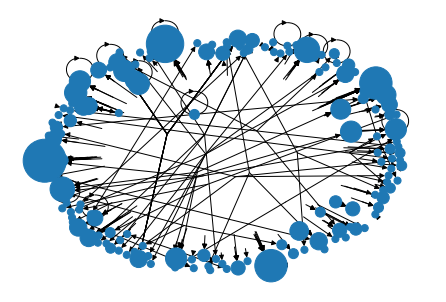

In [ ]:
node_sizes = [D.in_degree(n, weight='weight') * 50 for n in D.nodes]

%matplotlib inline
nx.draw(D, node_size=node_sizes)

Note that in this simplistic drawing, nodes with zero in-strength are not drawn on the diagram because their size is 0. This suits us fine; only the users who have been mentioned are drawn here.